In [44]:
from googleapiclient.discovery import build
import pandas as pd
from IPython.display import JSON
import json

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt

# NLP
from wordcloud import WordCloud
from nltk.corpus import stopwords

In [2]:
api_key = 'XXXX'

In [3]:
channel_ids = ['UCoOae5nYA7VqaXzerajD0lg',
               # more channels here
              ]

In [5]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

request = youtube.channels().list(
            part="snippet,contentDetails,statistics",
            id=','.join(channel_ids)
)
response = request.execute()

JSON(response)
        

<IPython.core.display.JSON object>

In [6]:
def get_channel_stats(youtube, channel_ids):
    all_data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    #loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
    
    return(pd.DataFrame(all_data))

In [7]:
channel_stat = get_channel_stats(youtube, channel_ids)

In [8]:
channel_stat

,channelName,subscribers,views,totalVideos,playlistId
0,Ali Abdaal,4580000,345184765,677,UUoOae5nYA7VqaXzerajD0lg


In [9]:
playlist_id = "UUoOae5nYA7VqaXzerajD0lg"

def get_video_ids(youtube, playlist_id):

    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet, contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part="snippet, contentDetails",
                    playlistId=playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token
        )
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')

    return video_ids

In [56]:
# get video IDs
video_ids = get_video_ids(youtube, playlist_id)

In [11]:
len(video_ids)

674

In [12]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = { 'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                             }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)


In [57]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,pN-QzM_pflM,Ali Abdaal,"If I Started Youtube In 2023, I'd Do This","🎙 If you liked this, you might like my weekly ...","[Ali Abdaal, Ali abdal]",2023-08-07T12:00:43Z,56211,4791,None,43,PT59S,hd,false
1,Fq1O5Tp7ohc,Ali Abdaal,The Ultimate App for Productivity #ad,Thanks to Notion for sponsoring this Short - c...,"[Ali Abdaal, Ali abdal]",2023-08-06T15:00:08Z,44464,2437,None,28,PT1M,hd,false
2,poc4ctbnDYA,Ali Abdaal,I Read 107 Productivity Books. Here's What Act...,To try everything Brilliant has to offer for f...,"[Ali Abdaal, Ali abdal, ali abdaal books, best...",2023-08-04T13:30:22Z,327188,13245,None,491,PT18M32S,hd,false
3,WlYFPeBpU4s,Ali Abdaal,The Myth of Failure ❌,"🎙 If you liked this, you might like my weekly ...","[Ali Abdaal, Ali abdal]",2023-08-03T12:00:27Z,47461,4776,None,32,PT41S,hd,false
4,rjcejdY_iNU,Ali Abdaal,Deep Diving into How I Run a $4 Million Business,Check out @Slack Pro and get 50% off with this...,"[Ali Abdaal, ali abdaal, business apps, apps f...",2023-08-02T13:00:44Z,106910,3610,None,867,PT33M16S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,7APfFjfnNBc,Ali Abdaal,Payphone (Maroon 5) - Katherine Macfarland & A...,"First cover of 2017! We both love this song, s...","[payphone, maroon 5, acoustic cover, cover]",2017-01-04T23:13:51Z,84656,2118,None,121,PT2M35S,hd,false
670,gBpBLTSCb4s,Ali Abdaal,6med UKCAT Crash Course - In a Nutshell,The 6med UKCAT Crash Course is the most effect...,"[6med, medical school, ukcat, medicine]",2016-05-09T18:45:18Z,15302,107,None,5,PT2M11S,hd,false
671,Va0tSdPADpA,Ali Abdaal,6med BMAT Crash Course - In a Nutshell,The 6med BMAT Crash Course is the most effecti...,"[BMAT, 6med, medicine, medical students]",2016-04-27T09:04:49Z,37826,277,None,9,PT2M18S,hd,false
672,XJHM0fEH3ss,Ali Abdaal,Rolling in the Deep (Adele) - Duranka Perera &...,Our first 'proper' video! One of our all-time ...,"[rolling in the deep, adele, cover, acoustic]",2016-04-05T09:05:29Z,55614,702,None,33,PT2M29S,hd,false


Analysis ideas
1. views per video
2. Like and comments vs views
3. Title length vs views
4. video duration
5. video upload schedule

## Data pre-processing

In [14]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [15]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [16]:
numeric_cols= ['viewCount','likeCount','favouriteCount','commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric , errors='coerce', axis=1)

In [17]:
 # published day in the week
 from dateutil import parser

 
 video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
 video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [18]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [19]:
video_df[['durationSecs','duration']]

,durationSecs,duration
0,59.0,PT59S
1,60.0,PT1M
2,1112.0,PT18M32S
3,41.0,PT41S
4,1996.0,PT33M16S
...,...,...
669,155.0,PT2M35S
670,131.0,PT2M11S
671,138.0,PT2M18S
672,149.0,PT2M29S


In [20]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [21]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishDayName,durationSecs,tagCount
0,pN-QzM_pflM,Ali Abdaal,"If I Started Youtube In 2023, I'd Do This","🎙 If you liked this, you might like my weekly ...","[Ali Abdaal, Ali abdal]",2023-08-07 12:00:43+00:00,55659.0,4763.0,NaN,43.0,PT59S,hd,false,Monday,59.0,2
1,Fq1O5Tp7ohc,Ali Abdaal,The Ultimate App for Productivity #ad,Thanks to Notion for sponsoring this Short - c...,"[Ali Abdaal, Ali abdal]",2023-08-06 15:00:08+00:00,44249.0,2416.0,NaN,28.0,PT1M,hd,false,Sunday,60.0,2
2,poc4ctbnDYA,Ali Abdaal,I Read 107 Productivity Books. Here's What Act...,To try everything Brilliant has to offer for f...,"[Ali Abdaal, Ali abdal, ali abdaal books, best...",2023-08-04 13:30:22+00:00,325816.0,13210.0,NaN,490.0,PT18M32S,hd,false,Friday,1112.0,19
3,WlYFPeBpU4s,Ali Abdaal,The Myth of Failure ❌,"🎙 If you liked this, you might like my weekly ...","[Ali Abdaal, Ali abdal]",2023-08-03 12:00:27+00:00,47221.0,4750.0,NaN,32.0,PT41S,hd,false,Thursday,41.0,2
4,rjcejdY_iNU,Ali Abdaal,Deep Diving into How I Run a $4 Million Business,Check out @Slack Pro and get 50% off with this...,"[Ali Abdaal, ali abdaal, business apps, apps f...",2023-08-02 13:00:44+00:00,106473.0,3607.0,NaN,868.0,PT33M16S,hd,false,Wednesday,1996.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,7APfFjfnNBc,Ali Abdaal,Payphone (Maroon 5) - Katherine Macfarland & A...,"First cover of 2017! We both love this song, s...","[payphone, maroon 5, acoustic cover, cover]",2017-01-04 23:13:51+00:00,84656.0,2118.0,NaN,121.0,PT2M35S,hd,false,Wednesday,155.0,4
670,gBpBLTSCb4s,Ali Abdaal,6med UKCAT Crash Course - In a Nutshell,The 6med UKCAT Crash Course is the most effect...,"[6med, medical school, ukcat, medicine]",2016-05-09 18:45:18+00:00,15301.0,107.0,NaN,5.0,PT2M11S,hd,false,Monday,131.0,4
671,Va0tSdPADpA,Ali Abdaal,6med BMAT Crash Course - In a Nutshell,The 6med BMAT Crash Course is the most effecti...,"[BMAT, 6med, medicine, medical students]",2016-04-27 09:04:49+00:00,37824.0,277.0,NaN,9.0,PT2M18S,hd,false,Wednesday,138.0,4
672,XJHM0fEH3ss,Ali Abdaal,Rolling in the Deep (Adele) - Duranka Perera &...,Our first 'proper' video! One of our all-time ...,"[rolling in the deep, adele, cover, acoustic]",2016-04-05 09:05:29+00:00,55614.0,702.0,NaN,33.0,PT2M29S,hd,false,Tuesday,149.0,4


## EDA

#### Best performing videos

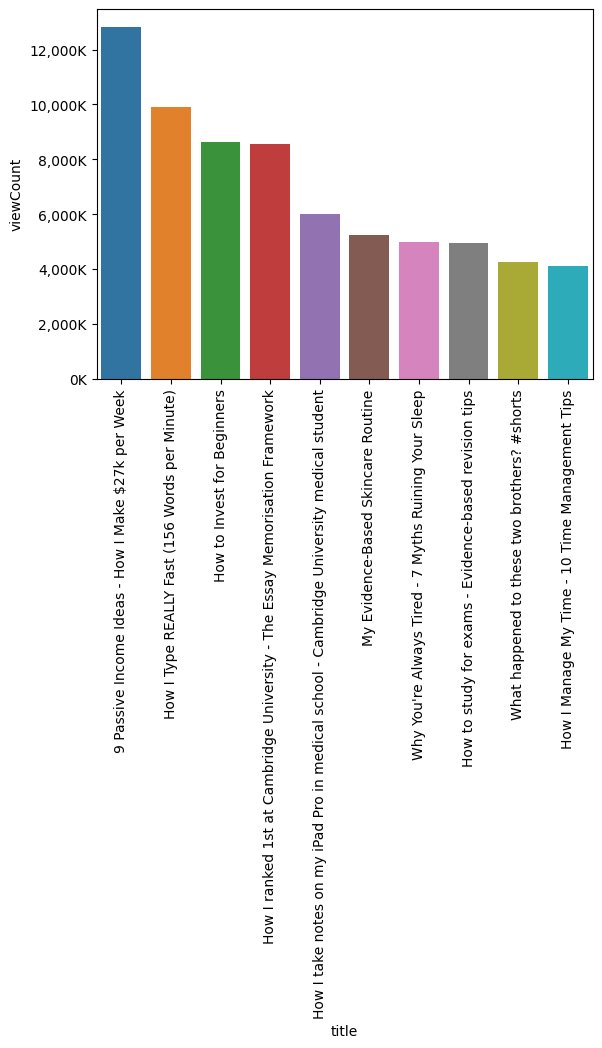

In [24]:
import matplotlib.ticker as ticker

ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:10])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + "K"))

#### Worst performing videos

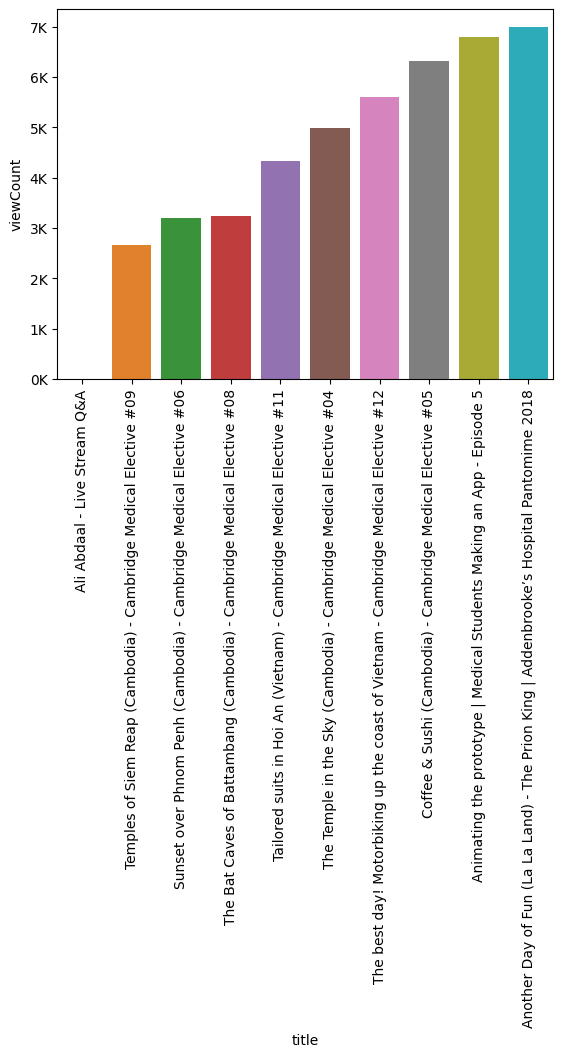

In [25]:
import matplotlib.ticker as ticker

ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:10])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + "K"))

#### View distribution per video

<AxesSubplot: xlabel='channelTitle', ylabel='viewCount'>

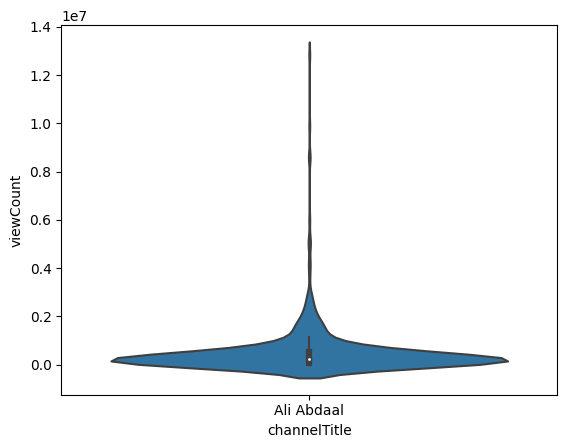

In [29]:
sns.violinplot(x = video_df['channelTitle'], y = video_df['viewCount'])

#### Views vs. likes nad comments

<AxesSubplot: xlabel='likeCount', ylabel='viewCount'>

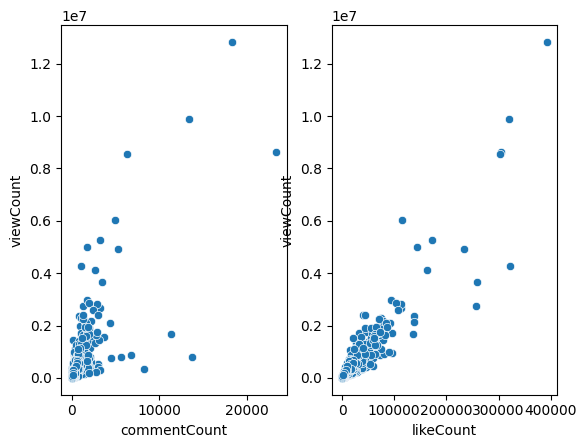

In [30]:
 fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y='viewCount', ax=ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y='viewCount', ax=ax[1])

#### Video duration

<AxesSubplot: xlabel='durationSecs', ylabel='Count'>

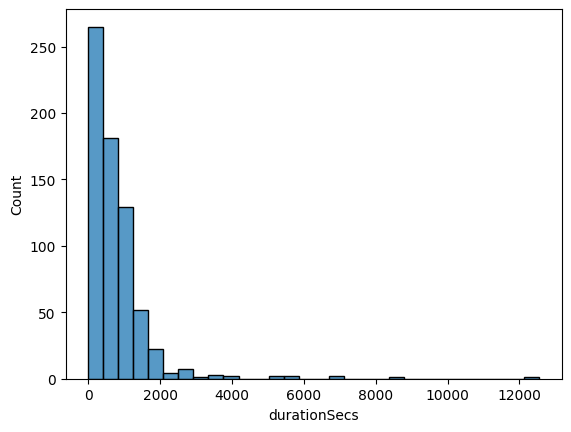

In [32]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

#### Wordcloud for video titles

In [50]:
import matplotlib.pyplot as plt 

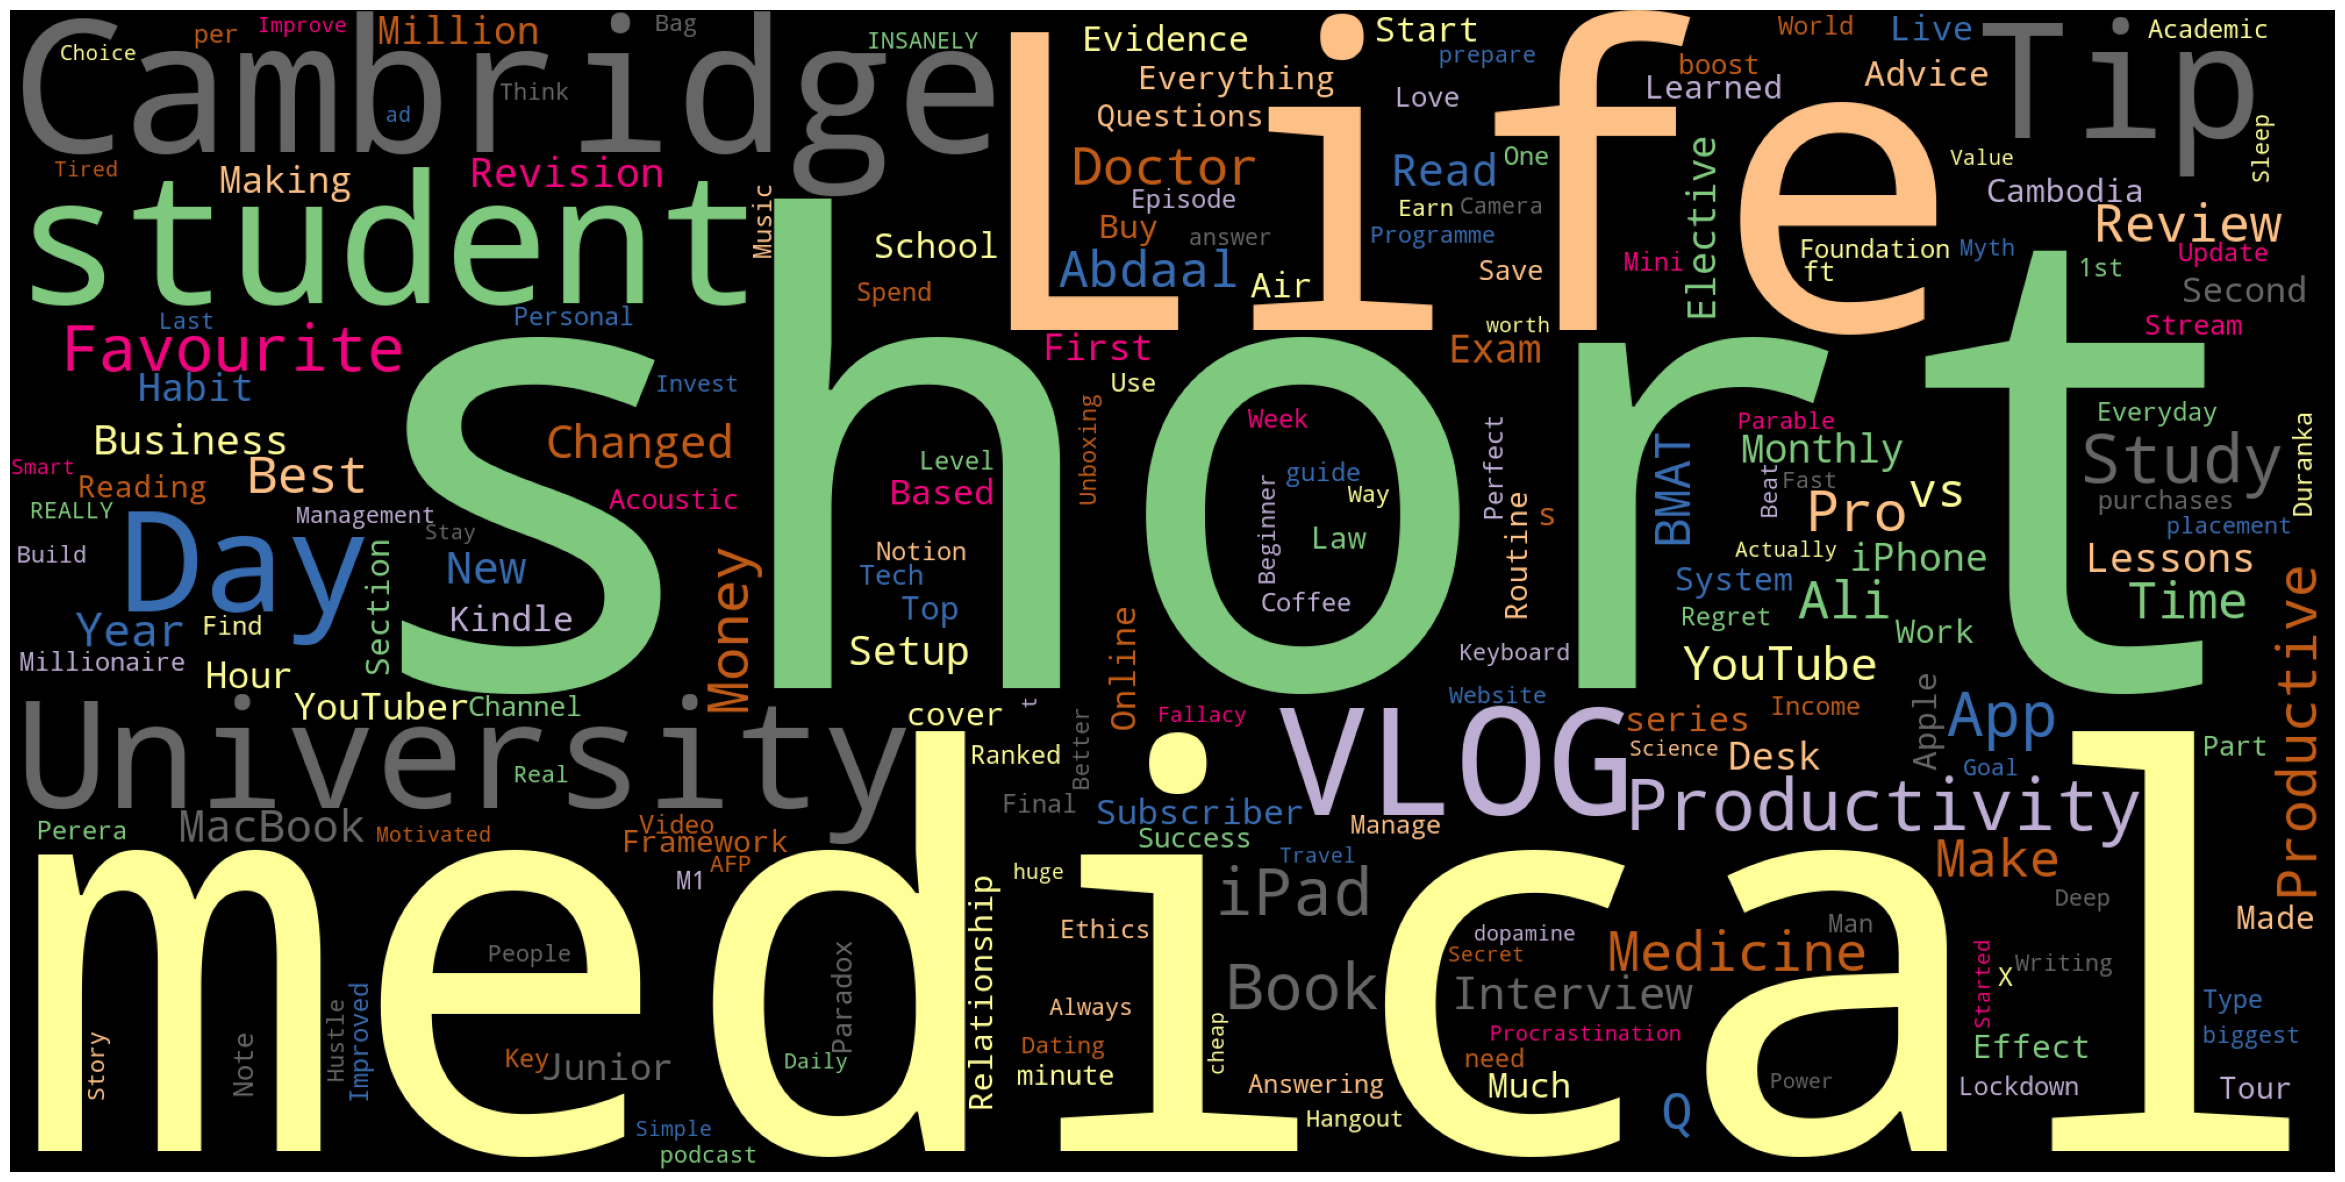

In [52]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

def plot_cloud(wordcloud):
  plt.figure(figsize=(30, 20))
  plt.imshow(wordcloud)
  plt.axis("off");

wordcloud = WordCloud(width = 2000, height=1000, random_state=1, background_color='black',
                      colormap='Accent', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

#### Upload Schecdule

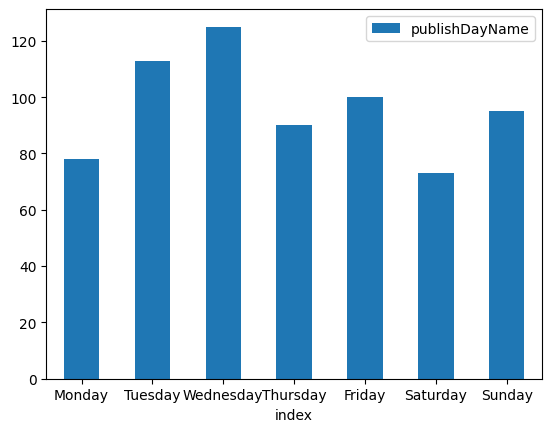

In [55]:
day_df = pd.DataFrame(video_df['publishDayName'].value_counts())
weekdays = ['Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='publishDayName', rot=0)